# Quantum Circuits
Quantum computers can only use a specific set of gates (universal gate set). Given the entanglers and their amplitudes found in Step 3, one can find corresponding representation of these operators in terms of elementary gates using the following procedure.

In [1]:
from qiskit import IBMQ
#IBMQ.save_account(MY_API_TOKEN)

In [2]:
import numpy as np
import tequila as tq
from utility import *

threshold = 1e-6 #VGG 1e-6 #Cutoff for UCC MP2 amplitudes and QCC ranking gradients
tol=threshold

First, we set up the Hamiltonian in Tequila's format and the unitary gates obtained in Step 3. 

In [3]:
R=1.5
bond_lengths = np.linspace(0.4,2.4,10)

molecule='h2'
basis='sto-3g'
qubit_transf='jw' #VGG 'bk' is not working well!

#Define number of entanglers to enter ansatz
n_ents = 1


In [4]:
estimate1=[]
satring_e=[]
U_QCC_e=[]
CO_QCC_e=[]
QCC_energy=[]
IBM_QC_e=[]

for R in bond_lengths:

#Quantum Chemistry methods

    xyz_data = get_molecular_data(molecule, geometry=R, xyz_format=True)
    hm = tq.quantumchemistry.Molecule(geometry=xyz_data, basis_set=basis)

    print('Number of spin-orbitals (qubits): {} \n'.format(2*hm.n_orbitals))

    #e0=hm.compute_energy(method='cisd') #VGG problem for H2
    e0=obtain_PES(molecule,[R], basis=basis,  method='cisd')
    hf_reference = hf_occ(2*hm.n_orbitals, hm.n_electrons)
    H = hm.make_hamiltonian()

##Got the first estimate for the energy

    estimate1.append(e0)
    print('CISD energy: {}'.format(e0))
    print("\nHamiltonian has {} terms\n".format(len(H)))

    #Rank entanglers using energy gradient criterion
    ranked_entangler_groupings = generate_QCC_gradient_groupings(H.to_openfermion(), 
                                                                 2*hm.n_orbitals, 
                                                                 hf_reference, 
                                                                 cutoff=threshold)

    print('Grouping gradient magnitudes (Grouping : Gradient magnitude):')
    for i in range(len(ranked_entangler_groupings)):
        print('{} : {}'.format(i+1,ranked_entangler_groupings[i][1]))

    entanglers = get_QCC_entanglers(ranked_entangler_groupings, n_ents, 2*hm.n_orbitals)

    print('\nSelected entanglers:')
    for ent in entanglers:
        print(ent)

    #Mean-field part of U (Omega):    
    U_MF = construct_QMF_ansatz(n_qubits = 2*hm.n_orbitals)

    #Entangling part of U:
    U_ENT = construct_QCC_ansatz(entanglers)

    U_QCC = U_MF + U_ENT

    E = tq.ExpectationValue(H=H, U=U_QCC)

    initial_vals = init_qcc_params(hf_reference, E.extract_variables())

##Got the initial energy estimate based on HF for QCC
    satring_e.append(tq.simulate(E, variables=initial_vals))

    #Minimize wrt the entangler amplitude and MF angles:
    result = tq.minimize(objective=E, method="BFGS", initial_values=initial_vals, tol=tol)
    U_QCC_e.append(result.energy)
    
##Got the optimization estimate based on U_QCC
    print('\nObtained QCC energy ({} entanglers): {}'.format(len(entanglers), result.energy))


#QC based methods - the VQE

    H_q = tq.QubitHamiltonian.from_openfermion(get_qubit_hamiltonian(
        molecule, R, basis, qubit_transf=qubit_transf)) #VGG note 'bk' is not working well

    stating_angels=result.angles
    vars={str(kw):stating_angels[kw] for kw in stating_angels}

    n_qubits=2*hm.n_orbitals

    a = tq.Variable("tau_0")
    U = construct_QMF_ansatz(n_qubits)
    U += tq.gates.ExpPauli(paulistring=tq.PauliString.from_string("X(0)Y(1)X(2)X(3)"), angle=a)
    
    E_q = tq.ExpectationValue(H=H_q, U=U)

#Perform VQE if feasable

    #Minimize wrt the entangler amplitude and MF angles:
    #result_q = tq.minimize(objective=E_q, method="BFGS", initial_values=vars, tol=tol)
    #CO_QCC_e.append(result_q.energy)
    #stating_angels=result_q.angles
    #vars={str(kw):stating_angels[kw] for kw in stating_angels}
    
    e_q=tq.simulate(E_q, variables=vars)
    QCC_energy.append(e_q)

#Got the circuit energy    
    print()
    print(U)
    print(vars)
    print("Energy:",e_q)


    # list of devices available can be found in ibmq account page
    %time q_result=tq.simulate(E_q, variables=vars, samples=100, backend="qiskit", device='ibmq_essex')# device='ibmq_16_melbourne')
    IBM_QC_e.append(q_result)
    
    print("QC_device:",q_result)
    print()
    

Number of spin-orbitals (qubits): 4 

r=0.4000, E =  -0.91415 Eh
CISD energy: [-0.91414971]

Hamiltonian has 15 terms

Grouping gradient magnitudes (Grouping : Gradient magnitude):
1 : 0.1645

Selected entanglers:
1.0 [X0 Y1 X2 X3]
Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 18 expectationvalues

active variables : 9

E=-0.90436139  angles= {beta_0: 3.141592653589793, gamma_0: 0.0, beta_1: 3.141592653589793, gamma_1: 0.0, beta_2: 0.0, gamma_2: 0.0, beta_3: 0.0, gamma_3: 0.0, tau_0: 0.0}  samples= None
E=-0.91270369  angles= {beta_0: 3.141592653589793, gamma_0: 0.0, beta_1: 3.141592653589793, gamma_1: 0.0, beta_2: 0.0, gamma_2: 0.0, beta_3: 0.0, gamma_3: 0.0, tau_0: 0.164515420794487}  samples= None
E=-0.91414970  angles= {beta_0: 3.141592653589793, gamma_0: 0.0, beta_1: 3.141592653589793


circuit: 
Rx(target=(0,), parameter=beta_0)
Rz(target=(0,), parameter=gamma_0)
Rx(target=(1,), parameter=beta_1)
Rz(target=(1,), parameter=gamma_1)
Rx(target=(2,), parameter=beta_2)
Rz(target=(2,), parameter=gamma_2)
Rx(target=(3,), parameter=beta_3)
Rz(target=(3,), parameter=gamma_3)
Exp-Pauli(target=(0, 1, 2, 3), control=(), parameter=tau_0, paulistring=X(0)Y(1)X(2)X(3))

{'beta_0': 3.1415926237874707, 'gamma_0': 0.0, 'beta_1': 3.1415926237874707, 'gamma_1': 0.0, 'beta_2': 0.0, 'gamma_2': 0.0, 'beta_3': 0.0, 'gamma_3': 0.0, 'tau_0': 0.3924896550091631}
Energy: -1.0866515505461478
CPU times: user 2.09 s, sys: 89.7 ms, total: 2.18 s
Wall time: 10min 42s
QC_device: -0.7348383306723102

Number of spin-orbitals (qubits): 4 

r=1.2889, E =  -1.03750 Eh
CISD energy: [-1.03750424]

Hamiltonian has 15 terms

Grouping gradient magnitudes (Grouping : Gradient magnitude):
1 : 0.2157

Selected entanglers:
1.0 [X0 Y1 X2 X3]
Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
b

Number of spin-orbitals (qubits): 4 

r=1.9556, E =  -0.95098 Eh
CISD energy: [-0.95097649]

Hamiltonian has 15 terms

Grouping gradient magnitudes (Grouping : Gradient magnitude):
1 : 0.2568

Selected entanglers:
1.0 [X0 Y1 X2 X3]
Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 18 expectationvalues

active variables : 9

E=-0.79312443  angles= {beta_0: 3.141592653589793, gamma_0: 0.0, beta_1: 3.141592653589793, gamma_1: 0.0, beta_2: 0.0, gamma_2: 0.0, beta_3: 0.0, gamma_3: 0.0, tau_0: 0.0}  samples= None
E=-0.85406966  angles= {beta_0: 3.141592653589793, gamma_0: 0.0, beta_1: 3.141592653589793, gamma_1: 0.0, beta_2: 0.0, gamma_2: 0.0, beta_3: 0.0, gamma_3: 0.0, tau_0: 0.2567594051361084}  samples= None
E=-0.94024040  angles= {beta_0: 3.141592574480568, gamma_0: 0.0, beta_1: 3.14159257448056

CPU times: user 3.12 s, sys: 247 ms, total: 3.37 s
Wall time: 1h 21min 59s
QC_device: -0.5897327421458309

Number of spin-orbitals (qubits): 4 

r=2.4000, E =  -0.93725 Eh
CISD energy: [-0.93725495]

Hamiltonian has 15 terms

Grouping gradient magnitudes (Grouping : Gradient magnitude):
1 : 0.2781

Selected entanglers:
1.0 [X0 Y1 X2 X3]
Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 18 expectationvalues

active variables : 9

E=-0.71591006  angles= {beta_0: 3.141592653589793, gamma_0: 0.0, beta_1: 3.141592653589793, gamma_1: 0.0, beta_2: 0.0, gamma_2: 0.0, beta_3: 0.0, gamma_3: 0.0, tau_0: 0.0}  samples= None
E=-0.78980809  angles= {beta_0: 3.141592653589793, gamma_0: 0.0, beta_1: 3.141592653589793, gamma_1: 0.0, beta_2: 0.0, gamma_2: 0.0, beta_3: 0.0, gamma_3: 0.0, tau_0: 0.278124451637268

One can check the expectation value to see it is near the ground state energy.

One can run the same experiment on a real quantum computer through IBM Quantum Experience (ibmq). After activating your account here (https://quantum-computing.ibm.com/login), copy the API token and execute the commented block below. 

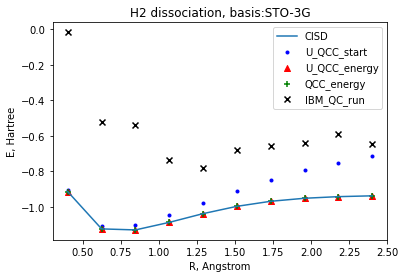

In [5]:
#Plot the PESs
import matplotlib.pyplot as plt

title_text=molecule.upper()+' dissociation, basis:'+basis.upper()
plt.title(title_text)
plt.xlabel('R, Angstrom')
plt.ylabel('E, Hartree')

plt.plot(bond_lengths, estimate1, label='CISD')
plt.scatter(bond_lengths, satring_e, label='U_QCC_start',marker='.', color='b')
plt.scatter(bond_lengths, U_QCC_e, label='U_QCC_energy', marker='^',color='r')
#plt.scatter(bond_lengths, CO_QCC_e, label='CO_QCC_e', marker='o',color='orange')
plt.scatter(bond_lengths, QCC_energy, label='QCC_energy', marker='+',color='g')
plt.scatter(bond_lengths, IBM_QC_e, label='IBM_QC_run',  marker='x', color='k')
plt.legend()

The following code block prints the circuit.

In [6]:
circ = tq.circuit.compiler.compile_exponential_pauli_gate(U)
tq.draw(circ, backend="qiskit")

     ┌────────────────────┐┌─────────────────────┐   ┌───┐                   »
q_0: ┤ RX(f((beta_0,))_0) ├┤ RZ(f((gamma_0,))_1) ├───┤ H ├──────■────────────»
     ├────────────────────┤├─────────────────────┤┌──┴───┴───┐┌─┴─┐          »
q_1: ┤ RX(f((beta_1,))_2) ├┤ RZ(f((gamma_1,))_3) ├┤ RX(pi/2) ├┤ X ├──■───────»
     ├────────────────────┤├─────────────────────┤└──┬───┬───┘└───┘┌─┴─┐     »
q_2: ┤ RX(f((beta_2,))_4) ├┤ RZ(f((gamma_2,))_5) ├───┤ H ├─────────┤ X ├──■──»
     ├────────────────────┤├─────────────────────┤   ├───┤         └───┘┌─┴─┐»
q_3: ┤ RX(f((beta_3,))_6) ├┤ RZ(f((gamma_3,))_7) ├───┤ H ├──────────────┤ X ├»
     └────────────────────┘└─────────────────────┘   └───┘              └───┘»
c_0: ════════════════════════════════════════════════════════════════════════»
                                                                             »
c_1: ════════════════════════════════════════════════════════════════════════»
                                                    